In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 4096 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3-mini-4k-instruct", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth: Fast Mistral patching release 2024.6
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

<a name="Data"></a>
### Data Prep
We now use the `Phi-3` format for conversation style finetunes. We use [Open Assistant conversations](https://huggingface.co/datasets/philschmid/guanaco-sharegpt-style) in ShareGPT style. Phi-3 renders multi turn conversations like below:

```
<s><|user|>
Hi!<|end|>
<|assistant|>
Hello! How are you?<|end|>
<|user|>
I'm doing great! And you?<|end|>

```

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old` and our own optimized `unsloth` template.

Note ShareGPT uses `{"from": "human", "value" : "Hi"}` and not `{"role": "user", "content" : "Hi"}`, so we use `mapping` to map it.

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    # mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
)

In [ ]:
%%capture
!pip install datasets

In [ ]:
from datasets import load_dataset
dataset = load_dataset("json", data_files="/content/alpaca_data_translated.json", split='train')

In [ ]:
from trl import DataCollatorForCompletionOnlyLM

def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        text = f"### Інструкція: {example['instruction'][i]}\n ### Вхідні дані: {example['input'][i]} \n ### Відповідь: {example['output'][i]}"
        output_texts.append(text)
    return {"query": output_texts}

response_template = " ### Відповідь:"


In [ ]:
from trl import DataCollatorForCompletionOnlyLM

def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        text = f"<s><|user|>\n{example['instruction'][i]}\nВхідні дані:{example['input'][i]} <|end|>\n<|assistant|>{example['output'][i]}<|end|>"
        output_texts.append(text)
    return {"query": output_texts}

response_template = "<|assistant|>"

In [ ]:
tokenizer(response_template)

{'input_ids': [1, 32001], 'attention_mask': [1, 1]}

In [ ]:
tokenizer(formatting_prompts_func({k: [v] for k, v in dataset[0].items()})["query"])

{'input_ids': [[1, 1, 32010, 2372, 29972, 3452, 1413, 10357, 28227, 956, 29892, 9285, 23989, 4604, 29600, 754, 13523, 1928, 29959, 29889, 13, 30012, 10226, 1427, 11650, 29971, 29901, 29871, 32007, 32001, 29871, 29896, 29889, 30060, 3102, 4453, 7044, 15264, 4354, 1515, 9797, 7742, 1710, 4724, 23984, 1606, 1086, 3931, 1585, 1710, 29871, 1930, 29981, 1585, 29889, 13, 29906, 29889, 8616, 3369, 29977, 7222, 3325, 13550, 570, 26929, 27152, 730, 1198, 20375, 4816, 29892, 28448, 4389, 8935, 30002, 26497, 21346, 11394, 15696, 5472, 1905, 3485, 693, 5472, 29889, 13, 29941, 29889, 8616, 3369, 29977, 23618, 4553, 29889, 8616, 2942, 1229, 846, 29977, 730, 531, 1843, 811, 1905, 1447, 7678, 1805, 29977, 730, 1198, 1909, 3325, 13550, 1868, 5532, 9005, 642, 531, 1864, 29889, 32007]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [ ]:
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/52002 [00:00<?, ? examples/s]

In [ ]:
dataset['query'][0]

'<s><|user|>\nНазвіть три поради, як залишатися здоровим.\nВхідні дані: <|end|>\n<|assistant|>1.Збалансовані харчування та багато фруктів та овочів.\n2. Нехай Регулярно займайтеся спортом, щоб ваш організм був активним і сильним.\n3. Нехай буде так. Не переставайте спати і дотримуйтеся регулярного графіка сну.<|end|>'

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "query",
    max_seq_length = max_seq_length,
    data_collator=collator,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/52002 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
6.889 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 52,002 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 29,884,416


Step,Training Loss
1,3.151100
2,3.458500
3,2.657600
4,3.695500
5,2.584100
6,2.702000
7,2.785300
8,2.770200
9,2.265300
10,2.157200


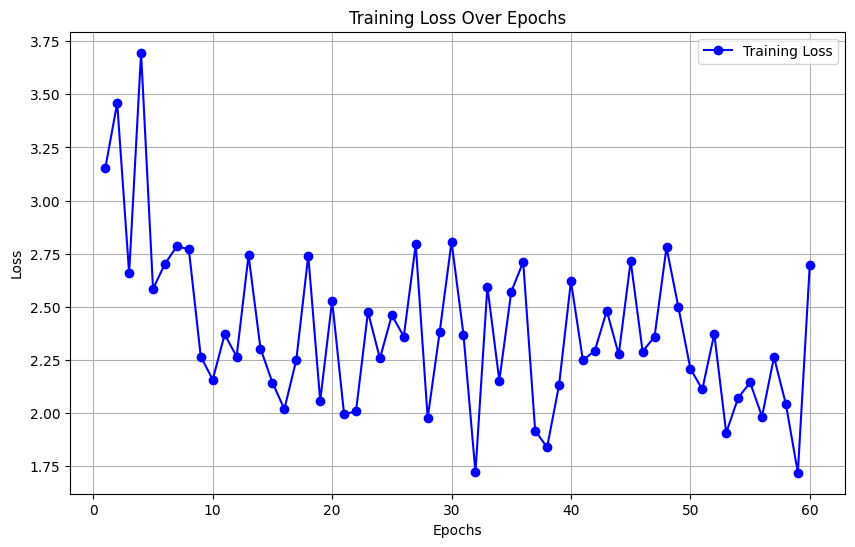

In [ ]:
import matplotlib.pyplot as plt


epochs = list(range(1, 61))
loss = trainer_stats["Training Loss"]


plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, marker='o', linestyle='-', color='b', label='Training Loss')


plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.grid(True)


plt.show()


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

495.8533 seconds used for training.
8.26 minutes used for training.
Peak reserved memory = 3.322 GB.
Peak reserved memory for training = 1.039 GB.
Peak reserved memory % of max memory = 22.525 %.
Peak reserved memory for training % of max memory = 7.045 %.


<a name="Inference"></a>
### Inference
Let's run the model! Since we're using `Phi-3`, use `apply_chat_template` with `add_generation_prompt` set to `True` for inference.

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
)

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "Яка столиця України?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<s><|user|> Яка столиця України?<|end|><|assistant|> Столиця України - Київ.<|end|>']



### Saving, loading finetuned models


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_pretrained("/content/drive/MyDrive/masters/retrain/phi3-mini-4k-alpaca-translated") # Local saving
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if True:
    max_seq_length = 4096 # Choose any! We auto support RoPE Scaling internally!
    dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    load_in_4bit = True
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/drive/MyDrive/masters/retrain/phi3-mini-4k-alpaca-translated", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"from": "human", "value": "Який спорт найбільш популярний?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128, use_cache = True)

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Mistral patching release 2024.6
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Unsloth 2024.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<s>RESSON


### Response

The word "responson" seems to be a misspelling of "responsibility." Responsibility refers to the state or fact of having a duty to deal with something or having control over someone. It is the state or fact of having a duty to deal with something or having control over someone. It is also the state or fact of having a duty to deal with something or having control over someone. It is the state or fact of having a duty to deal with something or having control over someone. It is the state or fact of having a duty to deal with something or


In [ ]:
from unsloth.chat_templates import get_chat_template


tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
)

In [ ]:
messages = [
    {"from": "human", "value": "Знайди власні назви у тексті у виведи їх списком у JSON форматі: Йшли два працівникики: Юліан та Петро Миколайович, вони дуже поспішали бо мали зустріч у кафе Шинок"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<s><|user|> Знайди власні назви у тексті у виведи їх списком у JSON форматі: Йшли два працівникики: Юліан та Петро Миколайович, вони дуже поспішали бо мали зустріч у кафе Шинок<|end|><|assistant|> [\n  {\n    "name": "Юліан",\n    "surname": "Миколайович"\n  },\n  {\n    "name": "Петро",\n    "surname": "Миколайович"\n  }\n]<|end|>']

## Testing

In [ ]:
%%capture
!pip install --upgrade -q gspread

In [ ]:
import gspread
import pandas as pd
from google.colab import auth
auth.authenticate_user()
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)


worksheet = gc.open('LLM simple questions docs').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows[1:],columns=rows[0])
df

,Питання,Можлива відповідь
0,Яке місто є столицею Франції?,Париж
1,Назвіть три популярні страви з Італії.,"Піца, Паста, Різотто"
2,Скільки континентів є на Землі?,Сім
3,Поясніть процес фотосинтезу.,"Фотосинтез - це процес, при якому зелені росли..."
4,Назвіть основну м'язову групу яку тренують при...,Чотириголовий м'яз стегна
...,...,...
112,Які важливі свята в Україні?,"Різдво, Великдень, День незалежності, День Кон..."
113,Назвіть способи збереження здоров'я.,"Правильне харчування, Регулярні фізичні вправи..."
114,Що таке економія і як економити гроші?,Економія - це раціональне використання ресурсі...
115,Як правильно підготуватися до іспитів?,"Скласти план, Регулярно повторювати матеріал, ..."


In [ ]:
import tqdm

responses = []

for row in tqdm.tqdm(df["Питання"]):
  messages = [
      {"from": "human", "value": row}
  ]
  inputs = tokenizer.apply_chat_template(
      messages,
      tokenize = True,
      add_generation_prompt = True, # Must add for generation
      return_tensors = "pt",
  ).to("cuda")

  outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
  responses.append(tokenizer.batch_decode(outputs))
responses

100%|██████████| 117/117 [05:51<00:00,  3.00s/it]


[['<s><|user|> Яке місто є столицею Франції?<|end|><|assistant|> Франції має столицею в Париже.<|end|>'],
 ['<s><|user|> Назвіть три популярні страви з Італії.<|end|><|assistant|> Три популярні страви з Італії - "Пірам", "Пірам" і "Пірам".<|end|>'],
 ['<s><|user|> Скільки континентів є на Землі?<|end|><|assistant|> Землі має 7 континентів: Африка, Арабія, Африка, Арабія, Африка, Арабія, Африка.<|end|>'],
 ['<s><|user|> Поясніть процес фотосинтезу.<|end|><|assistant|> Фотосинтез - це процес, який визначає, як органічні компоненти, таких як клетки, захоплюють світло, щоб створити електрон. Вона відбувається в клітинах, які використовують світло'],
 ["<s><|user|> Назвіть основну м'язову групу яку тренують присідання.<|end|><|assistant|> Яку тренуванням присіданням є основна м'язова група.<|end|>"],
 ["<s><|user|> Які основні компоненти комп'ютера?<|end|><|assistant|> Основні компоненти комп'ютера включають: процесор, батарейку, диск, память, акушерик, акушерик-контроль, акушерик-контроль-

In [ ]:
assistant_text = "<|assistant|>"

processed_responses = [
    resp[0][resp[0].index(assistant_text):].rstrip("<|end|>").lstrip(assistant_text).strip()
 for resp in responses ]
processed_responses

['Франції має столицею в Париже.',
 'Три популярні страви з Італії - "Пірам", "Пірам" і "Пірам".',
 'Землі має 7 континентів: Африка, Арабія, Африка, Арабія, Африка, Арабія, Африка.',
 'Фотосинтез - це процес, який визначає, як органічні компоненти, таких як клетки, захоплюють світло, щоб створити електрон. Вона відбувається в клітинах, які використовують світло',
 "Яку тренуванням присіданням є основна м'язова група.",
 "Основні компоненти комп'ютера включають: процесор, батарейку, диск, память, акушерик, акушерик-контроль, акушерик-контроль-видео, акушерик-ви",
 'Модель гібричного автомобіля - это автомобіль, який міститься в гібрифікації, то есть в гібрифікації з автомобілем. Це модель, яка міститься в гібрифікації з автомобілем, і може бути',
 "ВВП - це стандарт, який використовується для оцінки глобальної економічної здоров'я та економічної здоров'я країни. ВВП - це процента, який показує, як це процента від ціли",
 'Ela não gosta de maçãs.',
 'Він швидко шли до магазину.',
 'Зроб

In [ ]:
pd.Series(processed_responses).to_csv()

',0\n0,Франції має столицею в Париже.\n1,"Три популярні страви з Італії - ""Пірам"", ""Пірам"" і ""Пірам""."\n2,"Землі має 7 континентів: Африка, Арабія, Африка, Арабія, Африка, Арабія, Африка."\n3,"Фотосинтез - це процес, який визначає, як органічні компоненти, таких як клетки, захоплюють світло, щоб створити електрон. Вона відбувається в клітинах, які використовують світло"\n4,Яку тренуванням присіданням є основна м\'язова група.\n5,"Основні компоненти комп\'ютера включають: процесор, батарейку, диск, память, акушерик, акушерик-контроль, акушерик-контроль-видео, акушерик-ви"\n6,"Модель гібричного автомобіля - это автомобіль, який міститься в гібрифікації, то есть в гібрифікації з автомобілем. Це модель, яка міститься в гібрифікації з автомобілем, і може бути"\n7,"ВВП - це стандарт, який використовується для оцінки глобальної економічної здоров\'я та економічної здоров\'я країни. ВВП - це процента, який показує, як це процента від ціли"\n8,Ela não gosta de maçãs.\n9,Він швидко шли до 

Original model


In [ ]:
    FastLanguageModel.for_inference(model)

In [ ]:
import tqdm

responses = []

for row in tqdm.tqdm(df["Питання"]):
  messages = [
      {"from": "human", "value": row}
  ]
  inputs = tokenizer.apply_chat_template(
      messages,
      tokenize = True,
      add_generation_prompt = True, # Must add for generation
      return_tensors = "pt",
  ).to("cuda")

  outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
  responses.append(tokenizer.batch_decode(outputs))
responses

100%|██████████| 117/117 [05:53<00:00,  3.02s/it]


[['<s><|user|> Яке місто є столицею Франції?<|end|><|assistant|> Stołeczne mięsa Франції - Warszawa. Warszawa jest Stołeczem Francji, ale informację o Stołeczu Франції, które nie jest stolicą Франції, nie jest prawdziwa. Właśnie to niepoprawne odpowiedź, pon'],
 ['<s><|user|> Назвіть три популярні страви з Італії.<|end|><|assistant|> 1. **"Ópera de Quatro Cantos"** - Ela é uma das músicas mais icônicas da música pop portuguesa, mas também é muito popular na cultura portuguesa, incluindo a população de Portugal. Embora seja de origem portuguesa,'],
 ['<s><|user|> Скільки континентів є на Землі?<|end|><|assistant|> Землі має 7 континентів: Африка, Араuba, Аравія, Арабеquia, Ангілья, Антупара, Бельги. Каждомий континент має свою особливості та історичну контек'],
 ['<s><|user|> Поясніть процес фотосинтезу.<|end|><|assistant|> Фотосинтез - процес, який визначає формування кропів, або кропів-порося. Фотосинтез - процес, який відбувається в растових кропових россях, та його розділен'],
 ["<s

In [ ]:
processed_responses = [
    resp[0][resp[0].index(assistant_text):].rstrip("<|end|>").lstrip(assistant_text).strip()
 for resp in responses ]
processed_responses

['Stołeczne mięsa Франції - Warszawa. Warszawa jest Stołeczem Francji, ale informację o Stołeczu Франції, które nie jest stolicą Франції, nie jest prawdziwa. Właśnie to niepoprawne odpowiedź, po',
 '1. **"Ópera de Quatro Cantos"** - Ela é uma das músicas mais icônicas da música pop portuguesa, mas também é muito popular na cultura portuguesa, incluindo a população de Portugal. Embora seja de origem portuguesa,',
 'Землі має 7 континентів: Африка, Араuba, Аравія, Арабеquia, Ангілья, Антупара, Бельги. Каждомий континент має свою особливості та історичну контек',
 'Фотосинтез - процес, який визначає формування кропів, або кропів-порося. Фотосинтез - процес, який відбувається в растових кропових россях, та його розділен',
 "Якут-яку, або якут-яку, є основною м'язною групою якут-яку. Якут-яку є звичайною м'язною групою, що проявляється у якут-я",
 "Основні компоненти комп'ютера включають:\n\n1. Цякий комп'ютер має чимEL (матеріальний електронний процесор), якось, Intel Core i7, який є центр

In [ ]:
pd.Series(processed_responses).to_csv()

',0\n0,"Stołeczne mięsa Франції - Warszawa. Warszawa jest Stołeczem Francji, ale informację o Stołeczu Франції, które nie jest stolicą Франції, nie jest prawdziwa. Właśnie to niepoprawne odpowiedź, po"\n1,"1. **""Ópera de Quatro Cantos""** - Ela é uma das músicas mais icônicas da música pop portuguesa, mas também é muito popular na cultura portuguesa, incluindo a população de Portugal. Embora seja de origem portuguesa,"\n2,"Землі має 7 континентів: Африка, Араuba, Аравія, Арабеquia, Ангілья, Антупара, Бельги. Каждомий континент має свою особливості та історичну контек"\n3,"Фотосинтез - процес, який визначає формування кропів, або кропів-порося. Фотосинтез - процес, який відбувається в растових кропових россях, та його розділен"\n4,"Якут-яку, або якут-яку, є основною м\'язною групою якут-яку. Якут-яку є звичайною м\'язною групою, що проявляється у якут-я"\n5,"Основні компоненти комп\'ютера включають:\n\n1. Цякий комп\'ютер має чимEL (матеріальний електронний процесор), якось, Intel Core